"""
Generate data with specified changepoints
Switch position of changepoint and check if ppc can predict new changepoint
"""

In [43]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from theano import shared

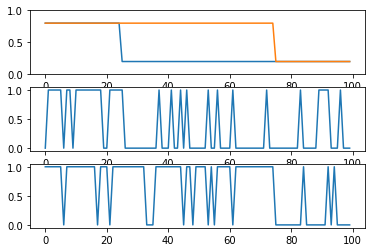

In [44]:
# Some poisson spiking
length = 100
states = 2
fit = int(5e4)
samples = 2000
idx = np.arange(length)

p_vals = [0.8,0.2]
tau1 = int(0.25*length)
tau2 = int(0.75*length)

lambda1 = np.ones(length)
lambda1[:tau1] = p_vals[0]
lambda1[tau1:] = p_vals[1]

lambda2 = np.ones(length)
lambda2[:tau2] = p_vals[0]
lambda2[tau2:] = p_vals[1]
  
data1 = np.random.random(length) < lambda1
data2 = np.random.random(length) < lambda2
#data_vec = np.random.poisson(true_r)

data_shared = shared(data1)

fig,ax = plt.subplots(3,1)
ax[0].plot(lambda1)
ax[0].plot(lambda2)
ax[0].set_ylim(0,1)
ax[1].plot(data1)
ax[2].plot(data2)
# ax[2].plot(np.convolve(data_vec,np.ones(20)))
# ax[0].set_ylabel("True Rate")
# ax[1].set_ylabel("Spikes")
# ax[2].set_ylabel("Firing Rate")

In [45]:
# def sbp(α, k=20):
#     """Stick breaking process geneerator."""

#     β = stats.beta(1, α).rvs(size=k)
#     w = β *  np.concatenate([[1],(1 - β[:-1]).cumprod()])
#     return w

In [46]:
#plt.plot(sbp(10,k=1000),'x')

In [47]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [48]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data1,states,axis=-1)])
print(mean_vals)

[0.5 0.2]


In [49]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = states,
                                  testval = mean_vals)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)

    # K = 5
    # alpha = pm.Gamma("alpha", 1, 1.0)
    # beta = pm.Beta("beta", 1.0, alpha, shape=K)
    # tau_latent = pm.Deterministic("tau_latent", stick_breaking(beta))
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [50]:
#idx[:,np.newaxis] - tau.tag.test_value[np.newaxis,:]
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])

In [51]:
with model:
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)

In [52]:
with model:
    #weight_stack = pm.math.stack([1-weight_stack[0][np.newaxis,:],weight_stack], axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [53]:
with model:
    lambda_ = pm.math.sum(np.multiply(weight_stack[:states],lambda_latent[:,np.newaxis]),axis=0)
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_shared)

(100,)


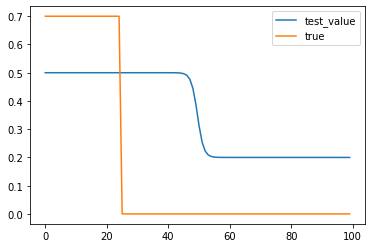

In [54]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(true_r,label='true')
plt.legend()
print(lambda_.tag.test_value.shape)

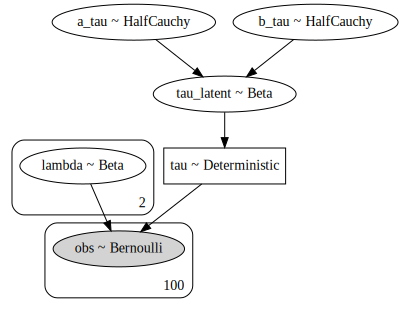

In [55]:
pm.model_to_graphviz(model)

In [56]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

Average Loss = 59.075: 100%|██████████| 100000/100000 [00:32<00:00, 3108.96it/s]
Finished [100%]: Average Loss = 59.074


In [57]:
# pm.traceplot(trace);

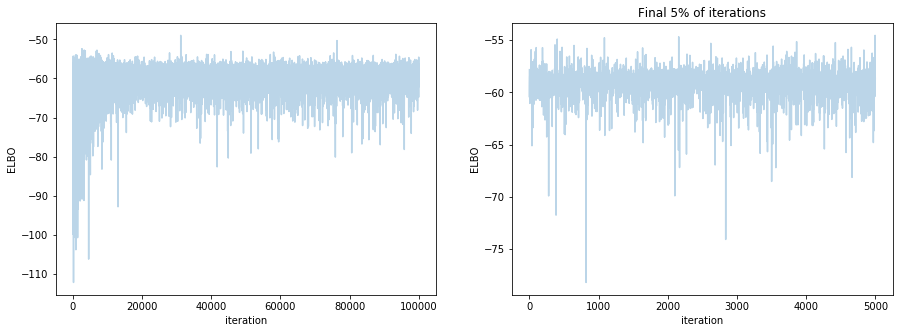

In [58]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [59]:
ppc1 = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:17<00:00, 116.29it/s]


In [60]:
data_shared.set_value(data2)
ppc2 = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:17<00:00, 115.84it/s]


Text(0.5, 1.0, 'Mean prediction')

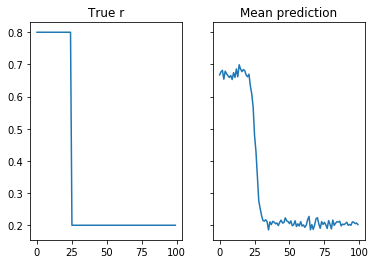

In [62]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(lambda1)
ax[1].plot(np.mean(ppc1['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

Text(0.5, 1.0, 'Mean prediction')

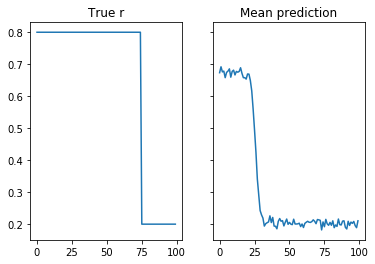

In [63]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(lambda2)
ax[1].plot(np.mean(ppc2['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [37]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
#tau_list = [this_fit['tau'] for this_fit in fit_list]
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 1)


array([25])

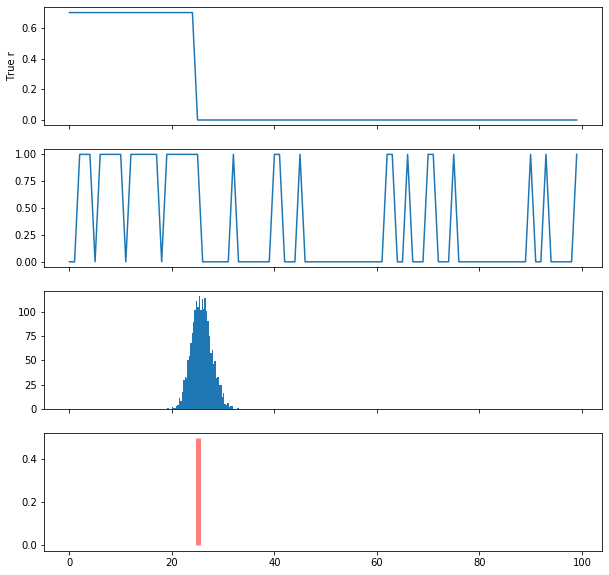

In [42]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
ax[0].plot(true_r)
ax[0].set_ylabel('True r')
ax[1].plot(data1)
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[3].vlines(mode_tau[tau_num],0,0.5,color='red',alpha=0.5,linewidth=5)
